# Exercise 2: Numerical Investigation of Hilbert-Schmidt Integral Operators

**AI and Inverse Problems** | **SS 25** 

In this notebook, we explore the properties of Hilbert-Schmidt integral operators through numerical analysis and the best rank-k approximation using SVD applied to image compression.

## Mathematical Background

A Hilbert-Schmidt integral operator $T: L^2(\Omega) \to L^2(\Omega')$ is defined as:

$$[Tx](t) = \int_\Omega k(s,t)x(s)\, \mathrm{d}s \quad \text{for almost every } t \in \Omega'$$

where $k \in L^2(\Omega \times \Omega')$ is the kernel. These operators are compact, which means they can be well-approximated by finite-rank operators.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from PIL import Image
import requests
from io import BytesIO
import os

# Set plotting parameters for better readability
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [12, 8]

## Exercise 1: Analyzing numerically the decay of singular values of different kernels.



You will:

1. **Discretize** the interval $[0, 1]$ to approximate the integral operator with a matrix.
2. **Construct kernel matrices** for the following kernel functions:
   - **Kernel A**: $ k_A(s, t) = e^{-|s - t|} $
   - **Kernel B**: $ k_B(s, t) = \min(s, t) $
   - **Kernel C**: $ k_C(s, t) = s \cdot t $
3. **Visualize** each kernel as a matrix heatmap.
4. **Compute and plot** the singular values to analyze their decay.


Discussion:
- which kernel shows the fastest decay in singular values?
- how does the decay of the kernels relate to the compactness of the integral operator?

### Connection to Inverse Problems

In inverse problems, we often need to recover an unknown function from measurements related to it by a Hilbert-Schmidt integral operator. The ill-posedness of such problems arises from the small singular values, which amplify noise in the inversion process. Understanding the spectral properties of these operators is therefore crucial for developing effective regularization strategies.


### Matrix representation of kernels
We start by discretizing the interval [0,1] and constructing matrix representations of different kernels.

In [2]:
# Discretize the interval [0, 1]
n = 100
points = np.linspace(0, 1, n)

# Function to create kernel matrices
def create_kernel_matrix(kernel_func):
    """Create a matrix representation of the kernel."""
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = kernel_func(points[i], points[j])
    # Scale by 1/n to approximate the integral
    return K / n

# Define different kernels
def kernel_A(s, t):
    return np.exp(-np.abs(s - t))

def kernel_B(s, t):
    return min(s, t)

def kernel_C(s, t):
    return s * t

# Create kernel matrices
K_A = create_kernel_matrix(kernel_A)
K_B = create_kernel_matrix(kernel_B)
K_C = create_kernel_matrix(kernel_C)

### Visualizing the Kernels

Let's visualize the matrix representation of each kernel to understand their structure.

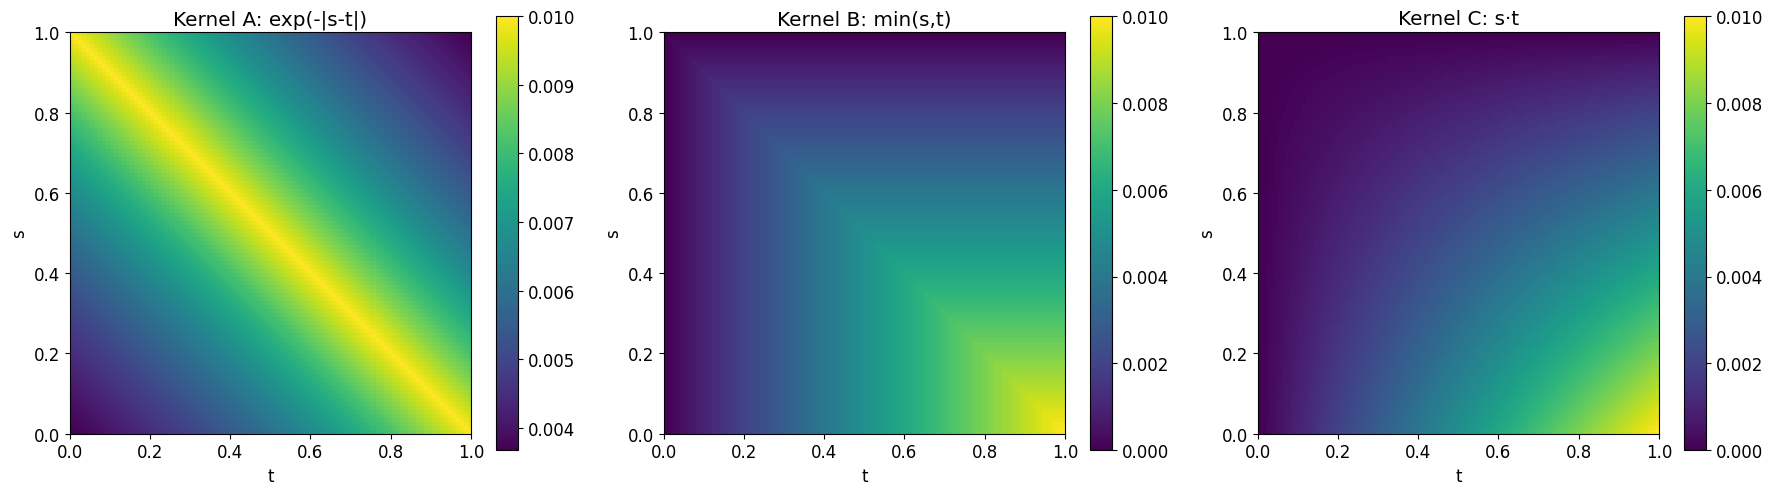

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

im0 = axes[0].imshow(K_A, cmap='viridis', extent=[0, 1, 0, 1])
axes[0].set_title('Kernel A: exp(-|s-t|)')
axes[0].set_xlabel('t')
axes[0].set_ylabel('s')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(K_B, cmap='viridis', extent=[0, 1, 0, 1])
axes[1].set_title('Kernel B: min(s,t)')
axes[1].set_xlabel('t')
axes[1].set_ylabel('s')
plt.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(K_C, cmap='viridis', extent=[0, 1, 0, 1])
axes[2].set_title('Kernel C: s·t')
axes[2].set_xlabel('t')
axes[2].set_ylabel('s')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()

### Computing and Analyzing Singular Values

Now we compute the singular value decomposition (SVD) of each kernel matrix to analyze their spectral properties.

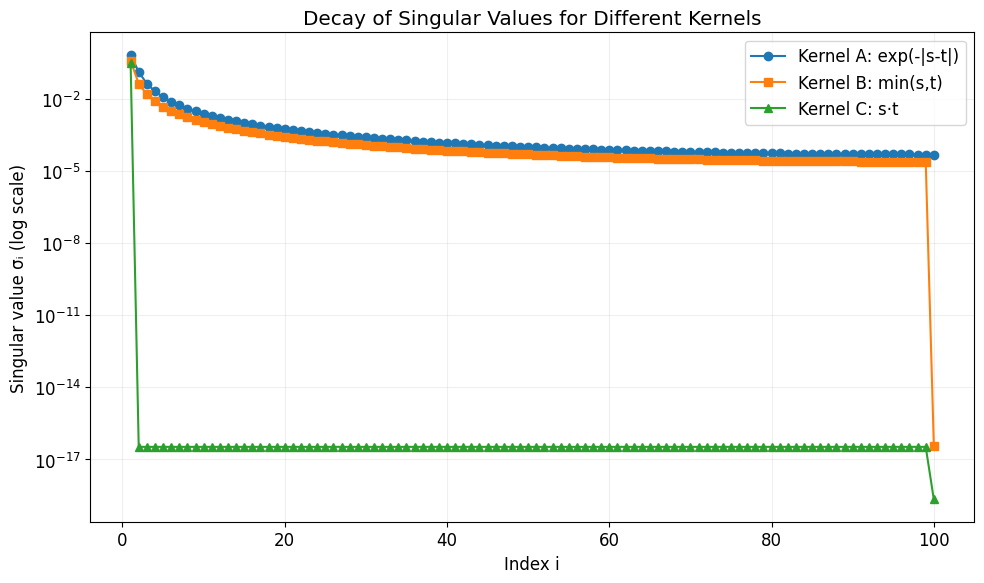

In [4]:
# Compute singular values
U_A, s_A, VT_A = linalg.svd(K_A)
U_B, s_B, VT_B = linalg.svd(K_B)
U_C, s_C, VT_C = linalg.svd(K_C)

# Plot singular values
plt.figure(figsize=(10, 6))
plt.semilogy(range(1, len(s_A) + 1), s_A, 'o-', label='Kernel A: exp(-|s-t|)')
plt.semilogy(range(1, len(s_B) + 1), s_B, 's-', label='Kernel B: min(s,t)')
plt.semilogy(range(1, len(s_C) + 1), s_C, '^-', label='Kernel C: s·t')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.xlabel('Index i')
plt.ylabel('Singular value σᵢ (log scale)')
plt.title('Decay of Singular Values for Different Kernels')
plt.legend()
plt.tight_layout()

## Exercise 2: SVD and best rank-$k$ approximation 

### **1. Mathematical Background**

Let $A\in \mathbb{R}^{m \times n}$ be a matrix. Its **Singular Value Decomposition** (SVD) is $A = U \Sigma V^T$ where

- $ U \in \mathbb{R}^{m \times m} $ and $ V \in \mathbb{R}^{n \times n} $ are orthogonal matrices,
- $ \Sigma \in \mathbb{R}^{m \times n} $ is diagonal with non-negative entries $ \sigma_1 \geq \sigma_2 \geq \dots \geq \sigma_r \geq 0 $, the **singular values** of $ A $.

The **best rank-**$ k $ **approximation** of $ A $ is given by truncating the SVD: $A_k = U_k \Sigma_k V_k^T$

This approximation minimizes the reconstruction error among all matrices of rank $ \leq k $.

---

### **2. Task Overview**
We will apply the best rank-k approximation to image compression.

You will:

1. **Load and convert** an image to a grayscale matrix.
2. **Compute the SVD** of the image matrix.
3. **Visualize** the singular values to understand their decay.
4. **Reconstruct the image** using different numbers of singular values $ k $.
5. **Evaluate and compare** the reconstruction error and compression ratio.


### Load the image

image matrix dimension: 4333 x 3250


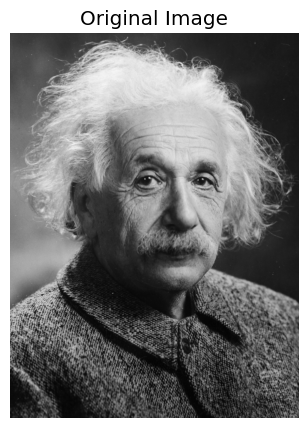

In [22]:
# Function to load a sample image
def get_sample_image():
    # We load an image of Einstein from the web
    url = "https://upload.wikimedia.org/wikipedia/commons/d/d3/Albert_Einstein_Head.jpg"
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('L')
    return img

# Get the image and convert to numpy array
img = get_sample_image()
A = np.array(img).astype(float)

# Display the original image
plt.figure(figsize=(8, 5))
plt.imshow(A, cmap='gray')
plt.title('Original Image')
plt.axis('off')

print(f'image matrix dimension: {A.shape[0]} x {A.shape[1]}')

### Computing SVD of the Image

Text(0.5, 1.0, 'Singular Values of the Image')

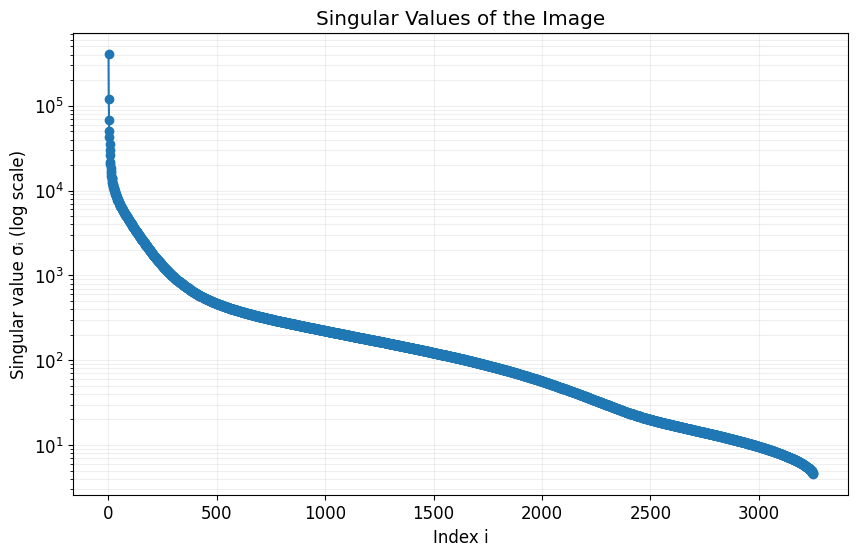

In [17]:
# Compute SVD
U, s, VT = linalg.svd(A, full_matrices=False)

# Plot singular values
plt.figure(figsize=(10, 6))
plt.semilogy(range(1, len(s) + 1), s, 'o-')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.xlabel('Index i')
plt.ylabel('Singular value σᵢ (log scale)')
plt.title('Singular Values of the Image')

### Image Reconstruction with Different Ranks

Now we'll reconstruct the image using different numbers of singular values and analyze the results.

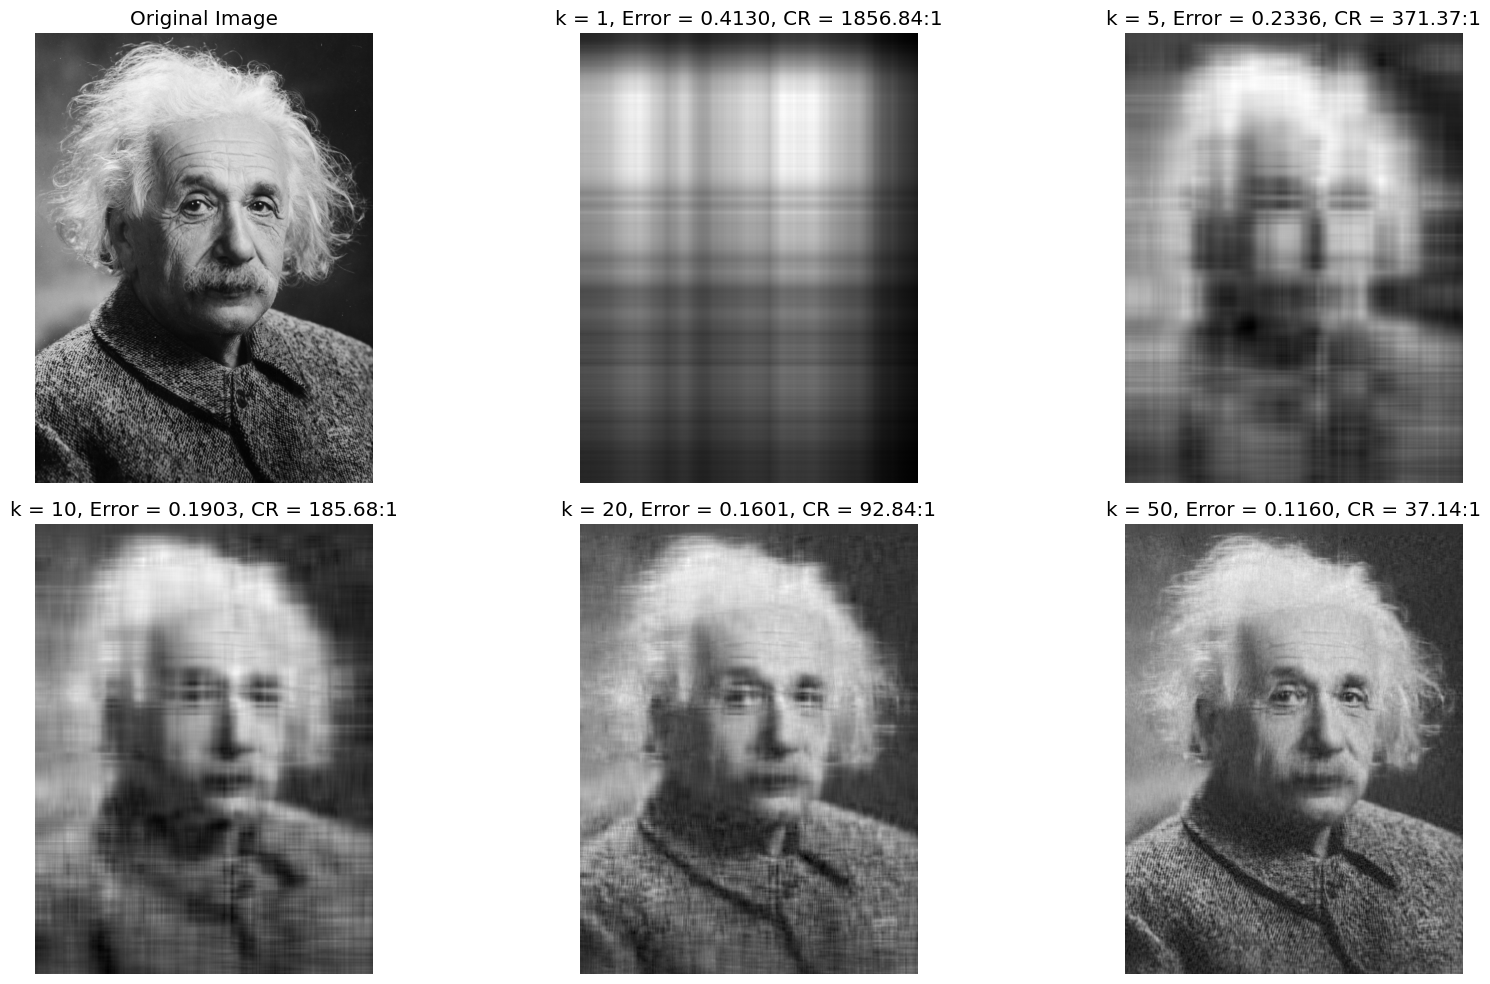

In [23]:
# Create low-rank approximations
k_values = [1, 5, 10, 20, 50]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Original image
axes[0].imshow(A, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Reconstructed images with different ranks
errors = []
compression_ratios = []

for i, k in enumerate(k_values):
    # Reconstruct using only k singular values
    A_k = U[:, :k] @ np.diag(s[:k]) @ VT[:k, :]
    
    # Calculate error
    error = np.linalg.norm(A - A_k, 'fro') / np.linalg.norm(A, 'fro')
    errors.append(error)
    
    # Calculate compression ratio
    original_size = A.shape[0] * A.shape[1]
    compressed_size = k * (A.shape[0] + A.shape[1] + 1) # We only need to save the entries of U_k, the diagonal of \Sigma_k, and V_k
    compression_ratio = original_size / compressed_size
    compression_ratios.append(compression_ratio)
    
    # Display image
    axes[i+1].imshow(A_k, cmap='gray')
    axes[i+1].set_title(f'k = {k}, Error = {error:.4f}, CR = {compression_ratio:.2f}:1')
    axes[i+1].axis('off')

plt.tight_layout()

### Analyzing Compression Performance

Text(0.5, 1.0, 'Reconstruction Error vs. Number of Singular Values')

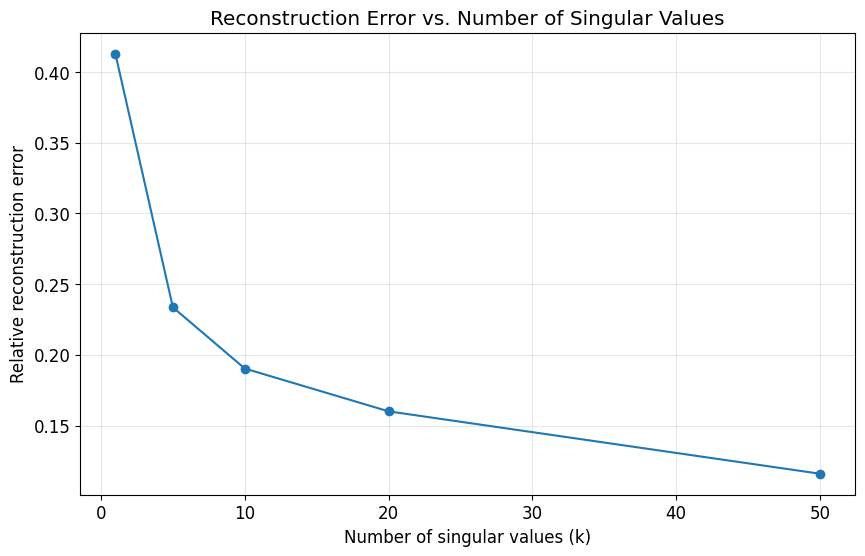

In [24]:
# Plot reconstruction error vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, errors, 'o-')
plt.grid(True, alpha=0.3)
plt.xlabel('Number of singular values (k)')
plt.ylabel('Relative reconstruction error')
plt.title('Reconstruction Error vs. Number of Singular Values')